In [2]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from e3nn import o3, nn
from e3nn.math import soft_one_hot_linspace, soft_unit_step
import matplotlib.pyplot as plt

## Define irreps

In [3]:
# Just define arbitrary irreps
irreps_input = o3.Irreps("10x0e + 5x1o + 2x2e")
irreps_query = o3.Irreps("11x0e + 4x1o")
irreps_key = o3.Irreps("12x0e + 3x1o")
irreps_output = o3.Irreps("14x0e + 6x1o")  # also irreps of the values
irreps_values = o3.Irreps("14x0e + 6x1o")  # also irreps of the values

num_nodes = 20

pos = torch.randn(num_nodes, 3)
# node values (features like mass, charge,...)
f = irreps_input.randn(num_nodes, -1)

# create graph
max_radius = 1.3
edge_src, edge_dst = radius_graph(pos, max_radius)
edge_vec = pos[edge_src] - pos[edge_dst]
# edge_vec is relative distance vector (edge feature)
edge_length = edge_vec.norm(dim=1)

## embedding of relative features (edges)

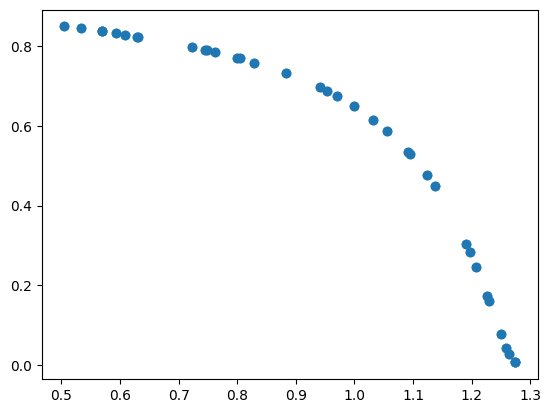

In [7]:
number_of_basis = 10
edge_length_embedded = soft_one_hot_linspace(
    edge_length,
    start=0.0,
    end=max_radius,
    number=number_of_basis,
    basis='smooth_finite',
    cutoff=True  # goes (smoothly) to zero at `start` and `end`
)
edge_length_embedded = edge_length_embedded.mul(number_of_basis**0.5)
edge_weight_cutoff = soft_unit_step(10 * (1 - edge_length / max_radius))
plt.scatter(edge_vec.norm(dim=1), edge_weight_cutoff)

## We will enrich the edge features with spherical harmonics

In [1]:
irreps_sh = o3.Irreps.spherical_harmonics(3)
edge_sh = o3.spherical_harmonics(irreps_sh, edge_vec, True, normalization='component')
tp_k = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_key, shared_weights=False)
fc_k = nn.FullyConnectedNet([number_of_basis, 16, tp_k.weight_numel], act=torch.nn.functional.silu)

tp_v = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)
fc_v = nn.FullyConnectedNet([number_of_basis, 16, tp_v.weight_numel], act=torch.nn.functional.silu)
dot = o3.FullyConnectedTensorProduct(irreps_query, irreps_key, "0e")

NameError: name 'o3' is not defined

In [14]:
h_q = o3.Linear(irreps_input, irreps_query)

## ATTENTION MECHANISM

In [16]:
# compute the queries (per node), keys (per edge) and values (per edge)
q = h_q(f)
k = tp_k(f[edge_src], edge_sh, fc_k(edge_length_embedded))
v = tp_v(f[edge_src], edge_sh, fc_v(edge_length_embedded))

# compute the softmax (per edge)
exp = edge_weight_cutoff[:, None] * dot(q[edge_dst], k).exp()  # compute the numerator
z = scatter(exp, edge_dst, dim=0, dim_size=len(f))  # compute the denominator (per nodes)
z[z == 0] = 1  # to avoid 0/0 when all the neighbors are exactly at the cutoff
alpha = exp / z[edge_dst]   # normalization

# compute the outputs (per node)
f_out = scatter(alpha.relu().sqrt() * v, edge_dst, dim=0, dim_size=len(f))